## Practical 3 : Linear Regression with Regularization

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import matplotlib.pyplot as plt
np.random.seed(123)

In [2]:
# Load data
X, y = datasets.load_boston(return_X_y=True)
print(f"No of data samples : {X.shape[0]}")

No of data samples : 506


In [3]:
# Split into training and testing datasets
M = 400                    # No. of samples in the training dataset
N = X.shape[0] - M         # No. of samples in the testing dataset
X_train, y_train = X[:M, ...], y[:M]
X_test , y_test  = X[M:, ...], y[M:]

In [4]:
# Reshape the data (sklearn is pedantic)
y_train, y_test = y_train[:, None], y_test[:, None]

In [5]:
# Normalize the data
scaler = StandardScaler() # To scale the X_train and X_test datasets

# Let's transform the X_train and X_test data
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [6]:
X_train = np.c_[np.ones_like(X_train[:, 0]) , X_train]
X_test  = np.c_[np.ones_like(X_test[:, 0])  , X_test ]

## Ridge Regression ($L_2$ Regularization)

In [7]:
# Let's initialize our weights
w = np.random.randn(X_train.shape[-1], 1)

In [8]:
def ridge_loss(y, y_pred, lam, w):
    return 0.5 * np.mean((y - y_pred) ** 2) + lam * np.sum(w[1:]**2)

def ridge_loss_grad(X, y, y_pred, lam, w):
    return ((1./X.shape[0]) * X.T @ (y_pred - y) +
            lam * np.r_[np.zeros_like(w[:1]), w[1:]])

In [9]:
# Start training now!
import time
import sys

epochs = 100
alpha  = 0.03
lam    = 0.1
train_losses = []
test_losses  = []
for _ in range(epochs):
    y_pred = X_train @ w
    w_grad = ridge_loss_grad(X_train, y_train, y_pred, lam, w)
    w = w - alpha * w_grad
    sys.stdout.write(f"\rEpochs : {_}, loss_train : {ridge_loss(y_train, y_pred, lam, w):.4f}, loss_test : {ridge_loss(y_test, X_test @ w, lam, w):.4f}")
    train_losses.append(ridge_loss(y_train, y_pred, lam, w))
    test_losses.append(ridge_loss(y_test, X_test @ w, lam, w))
    time.sleep(0.05)

Epochs : 99, loss_train : 16.3329, loss_test : 12.792495

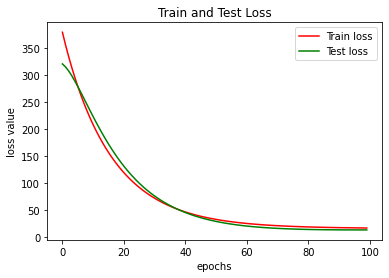

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_losses, color='r', label="Train loss")
plt.plot(test_losses, color='g', label="Test loss")
plt.title("Train and Test Loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.legend()
plt.show()

## Ridge Regression using Normal Equations

In [11]:
lam = .1
side_mat = lam * np.eye(X_train.shape[-1])
side_mat[0, 0] = 0
try:
    w_hat = np.linalg.solve((X_train.T @ X_train + side_mat), X_train.T @ y_train)
    y_train_hat = X_train @ w_hat
    y_test_hat  = X_test  @ w_hat
    print(f"Best train loss for Ridge Regression with lambda={lam} : {ridge_loss(y_train, y_train_hat, lam, w_hat)}")
    print(f"Best test  loss for Ridge Regression with lambda={lam} : {ridge_loss(y_test, y_test_hat, lam, w_hat)}")
except:
    print("Training matrix not invertible!!!")

Best train loss for Ridge Regression with lambda=0.1 : 16.67322284771611
Best test  loss for Ridge Regression with lambda=0.1 : 24.444776537019912


In [12]:
def loss(y, y_pred):
    return 0.5 * np.mean((y - y_pred)[..., 0] ** 2, axis=-1)

In [13]:
min_lam = 0.
max_lam = 200.
num_lam = 500

lams = np.linspace(min_lam, max_lam, num=num_lam)[:, np.newaxis, np.newaxis]

side_mat = lams * np.eye(X_train.shape[-1])
side_mat[..., 0, 0] = 0

w_hat = np.linalg.solve(X_train.T @ X_train + side_mat,
                        np.repeat((X_train.T @ y_train).T, lams.size, axis=0))

w_hat = w_hat[..., None]

y_train_hat = X_train @ w_hat
y_test_hat  = X_test  @ w_hat

train_losses = loss(y_train, y_train_hat)
test_losses  = loss(y_test, y_test_hat)

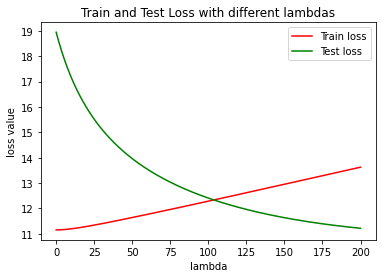

In [14]:
plt.plot(lams[..., 0, 0], train_losses, color='r', label="Train loss")
plt.plot(lams[..., 0, 0], test_losses, color='g', label="Test loss")
plt.title("Train and Test Loss with different lambdas")
plt.xlabel("lambda")
plt.ylabel("loss value")
plt.legend()
plt.show()

## Lasso Regression ($L_1$ Regularization)

In [15]:
# Let's initialize our weights
w = np.random.randn(X_train.shape[-1], 1)

In [16]:
def lasso_loss(y, y_pred, lam, w):
    return 0.5 * np.mean((y - y_pred) ** 2) + lam * np.sum(np.abs(w[1:]))

def lasso_loss_grad(X, y, y_pred, lam, w):
    return ((1./X.shape[0]) * X.T @ (y_pred - y) +
            lam * np.r_[np.zeros_like(w[:1]), np.ones_like(w[1:])])

In [17]:
# Start training now!
import time
import sys

epochs = 100
alpha  = 0.03
lam    = 0.1
train_losses = []
test_losses  = []
for _ in range(epochs):
    y_pred = X_train @ w
    w_grad = lasso_loss_grad(X_train, y_train, y_pred, lam, w)
    w = w - alpha * w_grad
    sys.stdout.write(f"\rEpochs : {_}, loss_train : {lasso_loss(y_train, y_pred, lam, w):.4f}, loss_test : {lasso_loss(y_test, X_test @ w, lam, w):.4f}")
    train_losses.append(lasso_loss(y_train, y_pred, lam, w))
    test_losses.append(lasso_loss(y_test, X_test @ w, lam, w))
    time.sleep(0.05)

Epochs : 99, loss_train : 14.0955, loss_test : 12.729661

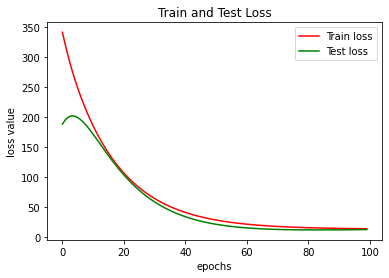

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_losses, color='r', label="Train loss")
plt.plot(test_losses, color='g', label="Test loss")
plt.title("Train and Test Loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.legend()
plt.show()